In [2]:
source("/data/srlab/ik936/NOTCH/notebooks/paper_utils.R")
library(presto)
library(uwot)
library(harmony)
library(singlecellmethods)

# Load data 

## meta

No cell level information, only donor level

In [6]:
library(GEOquery)

In [5]:
x <- GEOquery::getGEO('GSE134809')

Found 1 file(s)
GSE134809_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
File stored at: 
/tmp/RtmpQzGOBj/GPL18573.soft


In [7]:
meta_samples <- x$GSE134809_series_matrix.txt.gz@phenoData@data %>% 
    dplyr::select(title, geo_accession, matches(':ch1')) %>% 
    dplyr::mutate(sample_number = gsub('.*?(\\d+).*', '\\1', title)) 
colnames(meta_samples) <- gsub(':ch1', '', colnames(meta_samples))
head(meta_samples)

title,geo_accession,10x chemistry,status,tissue,sample_number
Ileal Involved 69,GSM3972009,V1,Involved,ileal,69
Ileal Uninvolved 68,GSM3972010,V1,Uninvolved,ileal,68
Ileal Involved 122,GSM3972011,V2,Involved,ileal,122
Ileal Uninvolved 123,GSM3972012,V2,Uninvolved,ileal,123
Ileal Involved 128,GSM3972013,V2,Involved,ileal,128
Ileal Uninvolved 129,GSM3972014,V2,Uninvolved,ileal,129


## Exprs

In [8]:
library(presto)
library(Matrix)
sumOverRowNames <- function(X) {
    name_factors <- factor(row.names(X))
    res <- presto:::sumGroups.dgCMatrix(X, name_factors)
    row.names(res) <- levels(name_factors)#[1:nrow(res)]
    colnames(res) <- colnames(X)
    return(res)
}

In [9]:
data_dir <- '/data/srlab/ik936/Fiona/data/martin/GSE134809_RAW'

In [10]:
read10x <- function(run, suffix) {
#     barcode.loc <- file.path(run, "barcodes.tsv")
#     gene.loc <- file.path(run, "genes.tsv")
#     matrix.loc <- file.path(run, "matrix.mtx")
    barcode.loc <- list.files(run, pattern = sprintf('_%s_barcodes.tsv', suffix), full.names = TRUE)
    gene.loc <- list.files(run, pattern = sprintf('_%s_genes.tsv', suffix), full.names = TRUE)
    matrix.loc <- list.files(run, pattern = sprintf('_%s_matrix.mtx', suffix), full.names = TRUE)

#     print(length(barcode.loc))
#     print(length(gene.loc))
#     print(length(matrix.loc))
#     return(1)
    
    data <- readMM(file = matrix.loc) %>% as("dgCMatrix")
    cell.names <- readLines(barcode.loc)
    cell.names <- gsub("-1$", "", cell.names)
    if (!missing(suffix)) {
        cell.names <- paste(cell.names, suffix, sep = "_")
    }
    
    gene.names <- fread(gene.loc, header = FALSE)$V2
    row.names(data) <- gene.names
    colnames(data) <- cell.names

    
    return(as(data, "dgCMatrix"))
#     return(as(sumOverRowNames(data), "dgCMatrix"))
}


In [110]:
exprs_raw <- Reduce(Matrix::cbind2, apply(meta_samples, 1, function(x) {
    message(x[['sample_number']])
    read10x(data_dir, x[['sample_number']])
}))

69
68
122
123
128
129
135
138
158
159
180
181
186
187
189
190
192
193
195
196
208
209


In [111]:
saveRDS(exprs_raw, '/data/srlab/ik936/Fiona/data/martin/exprs_raw.rds')

## Author marker info

In [20]:
library(openxlsx)

In [140]:
markers <- openxlsx::read.xlsx('/data/srlab/ik936/Fiona/data/martin/1-s2.0-S0092867419308967-mmc2.xlsx', 8) %>% 
    dplyr::rename(symbol = X1)

In [141]:
## normalize expression to be comparable to single cell exprs_norm
markers[, 2:ncol(markers)] <- log1p((2 ^ markers[, 2:ncol(markers)]) * 1e4)

In [142]:
idx_unique <- which(!duplicated(markers$symbol))
markers <- markers[idx_unique, ]
row.names(markers) <- markers$symbol
markers$symbol <- NULL

In [143]:
head(markers)

,ACKR1+.endothelial.cells,Activated.DC,Activated.fibroblasts,CD36+.endothelial.cells,Central.Memory.T.cells,Cytokines.low.Trm,Cytotoxic.T.cells,DC1,DC2,glial.cells,⋯,pDC,Pericytes,Plasmablasts,Resident.macrophages,Smooth.muscle.cells,T.(gd),TFH-like,Tregs,Type.1.cytokines.Trm,Type.3.cytokines.Trm
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RP11-34P13.7,0.009491555,0.009491555,0.020894581,0.02174400,0.009491555,0.011643873,0.009491555,0.009491555,0.01138221,0.009491555,⋯,0.009491555,0.009491555,0.009491555,0.01120362,0.009491555,0.009491555,0.012514697,0.011702009,0.009491555,0.010536424
FO538757.2,0.383910595,0.196832052,0.336808603,0.38608706,0.185088738,0.227730932,0.217646098,0.296096675,0.25211582,0.351166434,⋯,0.197317689,0.366340302,0.129147114,0.23000357,0.337818488,0.195939722,0.193171529,0.243403961,0.224186543,0.214160597
AP006222.2,0.150256646,0.077798029,0.167444508,0.17510228,0.053626680,0.076071615,0.101898286,0.145814949,0.04986200,0.400939719,⋯,0.199228420,0.219038772,0.030697122,0.12477716,0.285973949,0.059281629,0.043064225,0.075693070,0.083863164,0.071112004
RP4-669L17.10,0.022384343,0.009491555,0.032099028,0.02167688,0.016978591,0.017017770,0.009491555,0.017537226,0.01132440,0.009491555,⋯,0.030200473,0.044790619,0.018363892,0.01460908,0.009491555,0.009491555,0.009491555,0.016115365,0.013747014,0.013634877
RP11-206L10.9,0.042943059,0.040761993,0.086071299,0.04519987,0.049951400,0.038276531,0.047047652,0.102567507,0.06298085,0.042608403,⋯,0.029456426,0.095118261,0.057020768,0.07277294,0.033022403,0.049745680,0.044714951,0.063299793,0.017438676,0.048282847
FAM87B,0.009491555,0.009491555,0.009491555,0.01358344,0.009491555,0.009491555,0.009491555,0.009491555,0.01331160,0.009491555,⋯,0.009491555,0.009491555,0.009491555,0.01122136,0.033780034,0.009491555,0.009491555,0.009491555,0.009491555,0.009491555


# Label cell types

Redo their analysis

In [112]:
meta_raw <- data.table(cell_id = colnames(exprs_raw)) %>% 
    cbind(sample = paste0('S', gsub('.*_(.*)$', '\\1', colnames(exprs_raw))))
#     cbind(phase = c(rep('phase1', ncol(amp_exprs)), rep('phase2', ncol(exprs2)))) %>% 
#     cbind(sample = c(as.character(meta1$sample), as.character(meta2$batch)))

In [113]:
head(meta_raw)

cell_id,sample
<chr>,<chr>
AAACATACAAAACG_69,S69
AAACATACAAAAGC_69,S69
AAACATACAAACAG_69,S69
AAACATACAAACGA_69,S69
AAACATACAAAGCA_69,S69
AAACATACAAAGTG_69,S69


In [117]:
meta_raw$nUMI <- Matrix::colSums(exprs_raw)
meta_raw$nGene <- Matrix::colSums(exprs_raw > 0)
mito_genes <- grep("^MT-", rownames(exprs_raw), value = TRUE, ignore.case = TRUE)
meta_raw$percent_mito <- Matrix::colSums(exprs_raw[mito_genes, ])/Matrix::colSums(exprs_raw)
meta_data <- subset(meta_raw, (nGene > 500 & percent_mito < .2))



  S122   S123   S128   S129   S135   S138   S158   S159   S180   S181   S186 
737280 737280 737280 737280 737280 737280 737280 737280 737280 737280 737280 
  S187   S189   S190   S192   S193   S195   S196   S208   S209    S68    S69 
737280 737280 737280 737280 737280 737280 737280 737280 737280 737280 737280 

Also attach sample level metadata to cell metadata

In [121]:
exprs_raw <- exprs_raw[, meta_data$cell_id]
saveRDS(exprs_raw, '/data/srlab/ik936/Fiona/data/martin/exprs_raw.rds')

In [ ]:
sum(duplicated(row.names(exprs_raw)))

In [124]:
library(singlecellmethods)
genes_use <- which(Matrix::rowSums(exprs_raw[, meta_data$cell_id] != 0) >= 10)
exprs_norm <- exprs_raw[genes_use, meta_data$cell_id] %>% normalizeData(method = 'log')

vargenes_df <- singlecellmethods::findVariableGenes(exprs_norm, meta_data$sample)
var_genes <- unique(data.table(vargenes_df)[, head(.SD[order(-gene_dispersion_scaled)], 1000), by = group][, symbol])
message(length(var_genes))

pca_res <- exprs_norm[var_genes, ] %>% 
    singlecellmethods::scaleData() %>% 
    rARPACK::svds(30, 0, 30)
V <- pca_res$v %*% diag(pca_res$d)


5425


Harmony 1/10
Harmony 2/10
Harmony 3/10
Harmony 4/10
Harmony 5/10
Harmony converged after 5 iterations


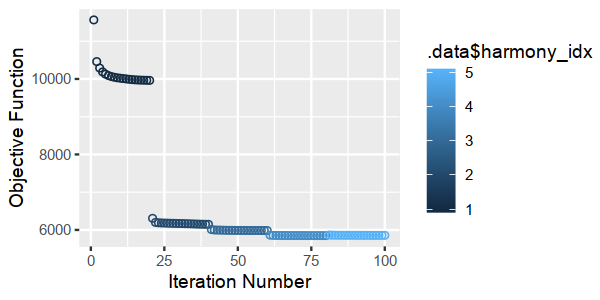

In [125]:
library(harmony)
fig.size(2.5, 5)
hres <- HarmonyMatrix(V, meta_data, c('sample'), 
                      theta = c(2), lambda = c(1), 
                      do_pca = FALSE, 
                      max.iter.cluster = 20,
                      return_object = FALSE, 
                      plot_convergence = TRUE)

In [126]:
umap_harmony <- umap(hres, n_neighbors = 30, learning_rate = 0.5, init = "pca", metric = 'cosine',     
                     min_dist = .3, n_threads = 8, approx_pow = TRUE)


In [128]:
save(meta_data, exprs_norm, vargenes_df, var_genes, hres, umap_harmony, V,
     file = '/data/srlab/ik936/Fiona/data/martin/cache.rda')

## Clusters

In [130]:
snn <- singlecellmethods:::buildSNN_fromFeatures(hres, prune_snn = 1/25, nn_k = 30, nn_eps = 0.5)

In [131]:
ids_ref <- singlecellmethods:::leidenCluster(snn, c(.05, .01, .005, .001), min_cluster_size = 10, 
                                             verbose = TRUE, pythondir = '/Users/ikorsuns/anaconda3/bin/python')


Resolution 0.050000 yielded 53 clusters
Resolution 0.010000 yielded 17 clusters
Resolution 0.005000 yielded 13 clusters
Resolution 0.001000 yielded 9 clusters


Warning message:
“Removed 5 rows containing missing values (geom_point_rast).”

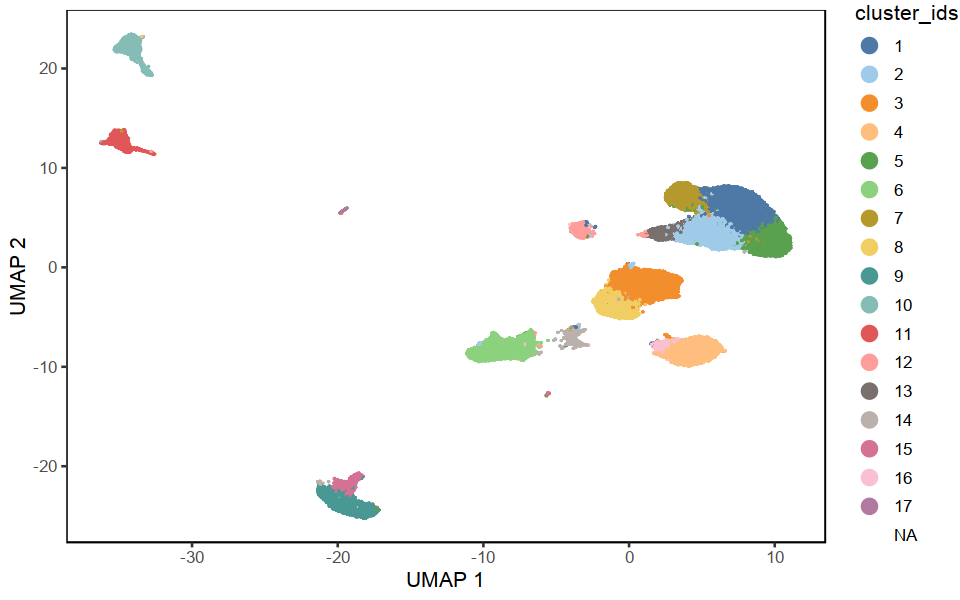

In [559]:
fig.size(5, 8)
do_scatter(
    umap_harmony, 
    cbind(meta_data, cluster_ids = factor(ids_ref[, 2])),
    'cluster_ids',
    palette_use = tableau_color_pal('Tableau 20')(20), no_guides = FALSE, do_labels = FALSE
)


# plot_clusters($`res_1.0000e-01`, ids_ref$`res_1.0000e-01`, umap_use = umap_harmony) + 
# plot_clusters(ids_ref$`res_5.0000e-01`, ids_ref$`res_5.0000e-01`, umap_use = umap_harmony)

Warning message:
“Removed 5 rows containing missing values (geom_point_rast).”

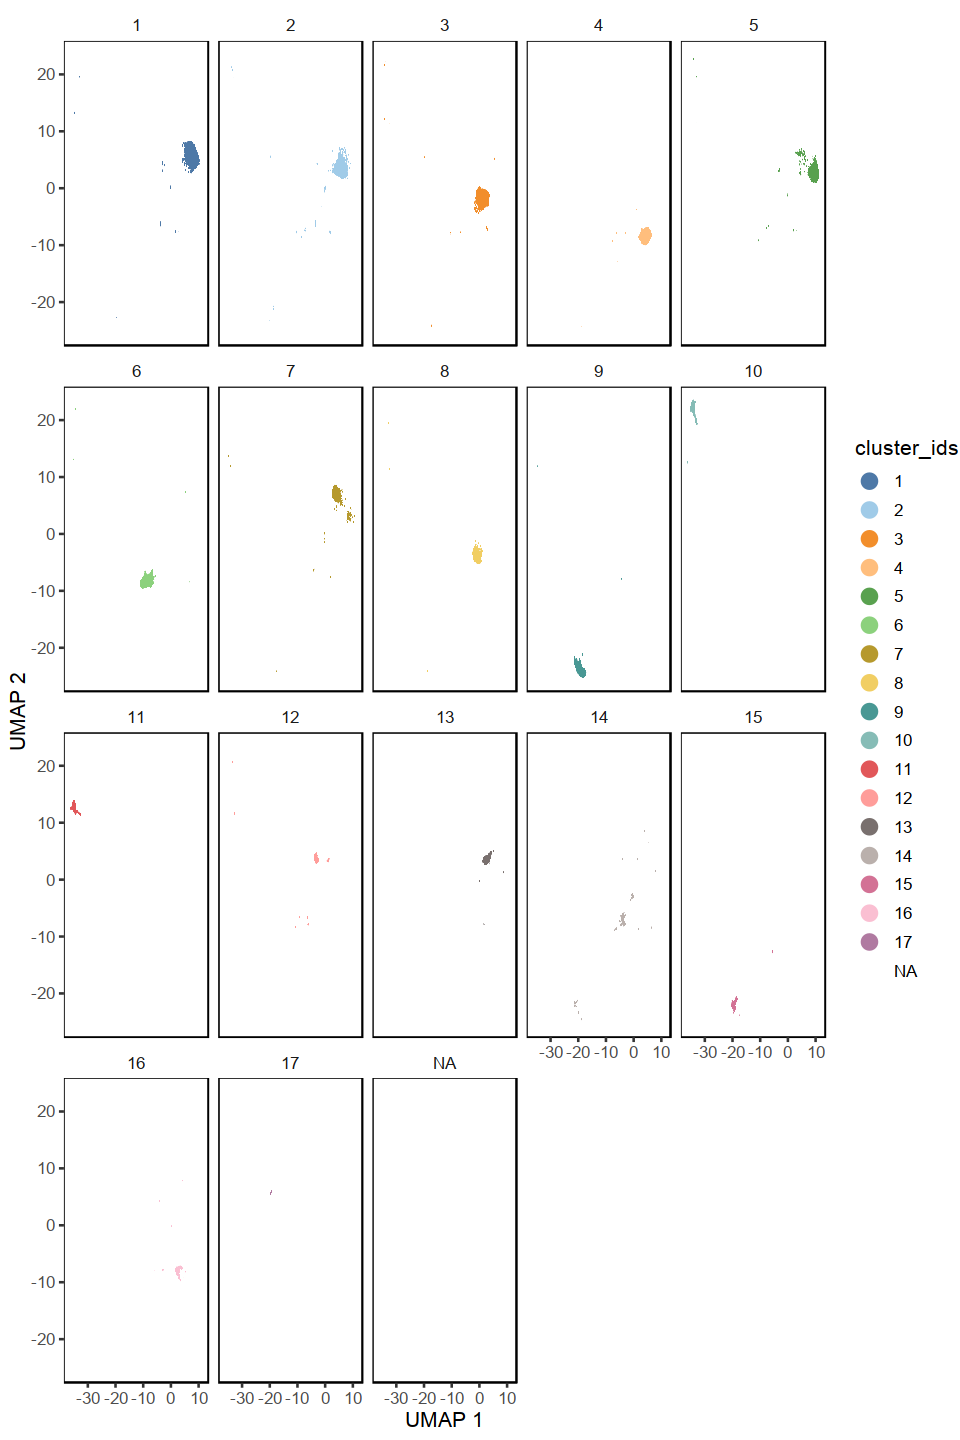

In [558]:
fig.size(12, 8)
do_scatter(
    umap_harmony, 
    cbind(meta_data, cluster_ids = factor(ids_ref[, 2])),
    'cluster_ids',
    palette_use = tableau_color_pal('Tableau 20')(20), no_guides = FALSE, do_labels = FALSE
) + 
facet_wrap(~cluster_ids)


# plot_clusters($`res_1.0000e-01`, ids_ref$`res_1.0000e-01`, umap_use = umap_harmony) + 
# plot_clusters(ids_ref$`res_5.0000e-01`, ids_ref$`res_5.0000e-01`, umap_use = umap_harmony)

Warning message:
“Ignoring unknown parameters: label.size”Warning message:
“Ignoring unknown parameters: label.size”Warning message:
“Ignoring unknown parameters: label.size”Warning message:
“Removed 5 rows containing missing values (geom_point_rast).”Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”

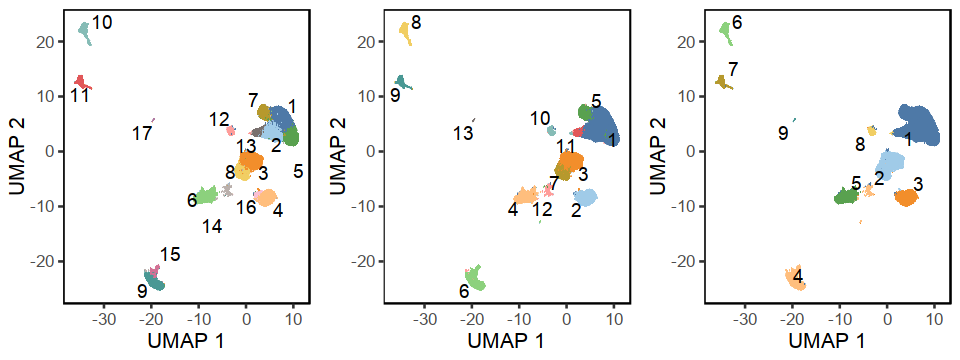

In [134]:
fig.size(3, 8)
Reduce(`+`, apply(ids_ref[, 2:4], 2, function(cluster_ids) {
    do_scatter(
        umap_harmony, 
        cbind(meta_data, cluster_ids = factor(cluster_ids)),
        'cluster_ids',
        palette_use = tableau_color_pal('Tableau 20')(20)
    )
}))

# plot_clusters($`res_1.0000e-01`, ids_ref$`res_1.0000e-01`, umap_use = umap_harmony) + 
# plot_clusters(ids_ref$`res_5.0000e-01`, ids_ref$`res_5.0000e-01`, umap_use = umap_harmony)

In [132]:
save(snn, ids_ref,
     file = '/data/srlab/ik936/Fiona/data/martin/cache2.rda')

In [302]:
clusters <- ids_ref[, 2]

In [303]:
table(clusters)

clusters
    1     2     3     4     5     6     7     8     9    10    11    12    13 
11663  7558  7016  6851  6374  4314  3631  3322  2887  1935  1700  1337  1293 
   14    15    16    17 
  928   742   605   288 

## Correlate clusters with markers

In [304]:
idx_use <- which(!is.na(clusters))
groups <- factor(clusters)
exprs_clusters <- presto::sumGroups(exprs_norm[, idx_use], groups[idx_use], 1) %>% t
row.names(exprs_clusters) <- row.names(exprs_norm)
colnames(exprs_clusters) <- levels(groups)

In [379]:
## select genes that are specific to less than 10 of the cell types 
gini <- 1 / rowSums(prop.table(as.matrix(markers), 1) ^ 2)
genes_variable <- names(gini)[which(gini < 15)]
# fig.size(2.5, 5)
# hist(gini)

In [382]:
genes_common <- intersect(row.names(exprs_norm), row.names(markers))# %>% intersect(genes_variable)
res <- cor(exprs_clusters[genes_common, ], markers[genes_common, ], method = 'spearman')
# res_norm <- diag(1 / apply(res, 1, max)) %*% res
# res_norm <- apply(res, 1, scales::rescale) %>% t()

res_norm <- apply(res, 2, scales::rescale)
colnames(res_norm) <- colnames(res)
row.names(res_norm) <- row.names(res)

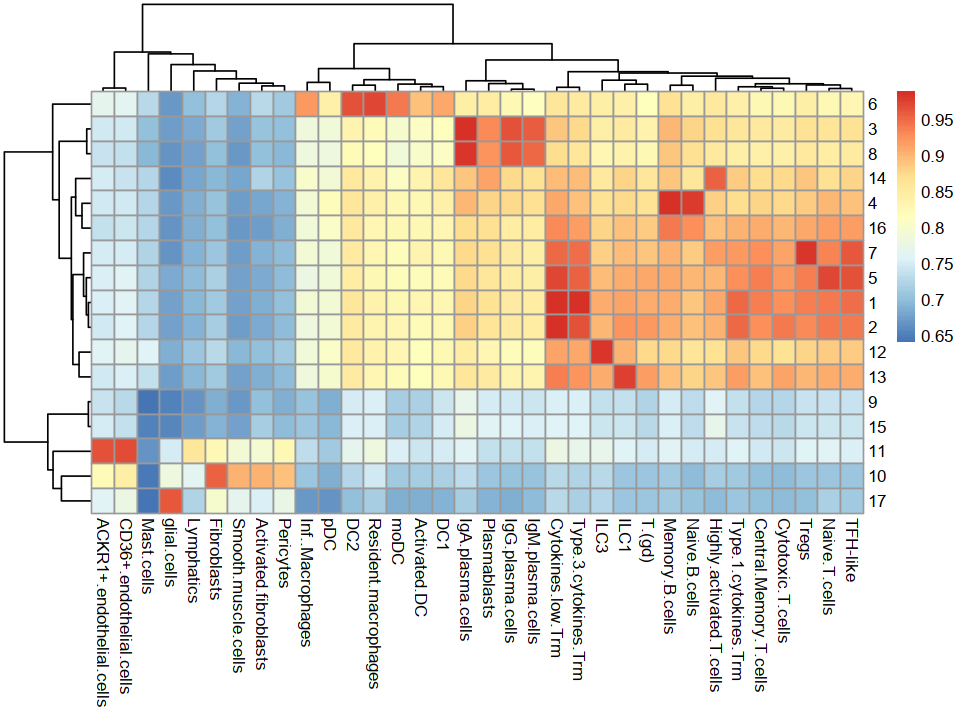

In [383]:
fig.size(6, 8)
library(pheatmap)
pheatmap(res)

## Assign names

In [318]:
name_clusters <- function(name_list, clusters) {
        cluster_labels <- Reduce(rbind, lapply(names(name_list), function(y) {
            data.table(cell_type = y, cluster_ids = name_list[[y]])
        }))
        data.table(cluster_ids = clusters) %>%
            dplyr::left_join(cluster_labels, by = "cluster_ids") %>% 
            dplyr::select(-cluster_ids) %>% 
            with(cell_type)
}

In [395]:
# # genes_use <- which(Matrix::rowSums(exprs_norm != 0) >= 10)
# genes_use <- which(!duplicated(row.names(exprs_norm)))
# idx_use <- which(!is.na(clusters))
# dge <- presto::wilcoxauc(exprs_norm[genes_use, idx_use], clusters[idx_use])

In [456]:
name_list <- list(
#     mast_cells = c(17),
    endothelial = c(11),
    glial = c(17),
    mesenchymal = c(10),
    meyloid = c(6),
    plasma = c(3, 8),
    tcells = c(7, 1, 5, 2, 14),
    bcells = c(4, 16),
    epithelial = c(9, 15),
    ilc1 = 13,
    ilc3 = 12
#     `NA` = c()
)
cell_type <- name_clusters(name_list, clusters)


In [457]:
setdiff(1:17, as.integer(unlist(name_list)))
table(cell_type)

integer(0)

cell_type
     bcells endothelial  epithelial       glial        ilc1        ilc3 
       7456        1700        3629         288        1293        1337 
mesenchymal     meyloid      plasma      tcells 
       1935        4314       10338       30154 

In [458]:
meta_data$cell_type_coarse <- cell_type

## Subtypes of mesenchymal cells

In [399]:
## subcluster cluster 10 to recover fibroblasts and such 

In [532]:
idx <- which(meta_data$cell_type_coarse == 'mesenchymal')

snn_fb <- singlecellmethods:::buildSNN_fromFeatures(hres[idx, ], prune_snn = 1/25, nn_k = 30, nn_eps = 0.5)

ids_ref_fb <- singlecellmethods:::leidenCluster(snn_fb, c(.5, .1), min_cluster_size = 10, 
                                             verbose = TRUE, pythondir = '/Users/ikorsuns/anaconda3/bin/python')


In [533]:
clusters <- ids_ref_fb[, 1]

In [534]:
table(clusters)
sum(is.na(clusters))

clusters
  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17 
296 233 221 176 176 142 104 103  98  81  81  53  51  48  24  13  10 

[1] 25

In [535]:
groups <- factor(clusters)
idx_nna <- which(!is.na(clusters))
exprs_clusters <- presto::sumGroups(exprs_norm[, idx][, idx_nna], clusters[idx_nna], 1) %>% t()
row.names(exprs_clusters) <- row.names(exprs_norm)
colnames(exprs_clusters) <- levels(groups)

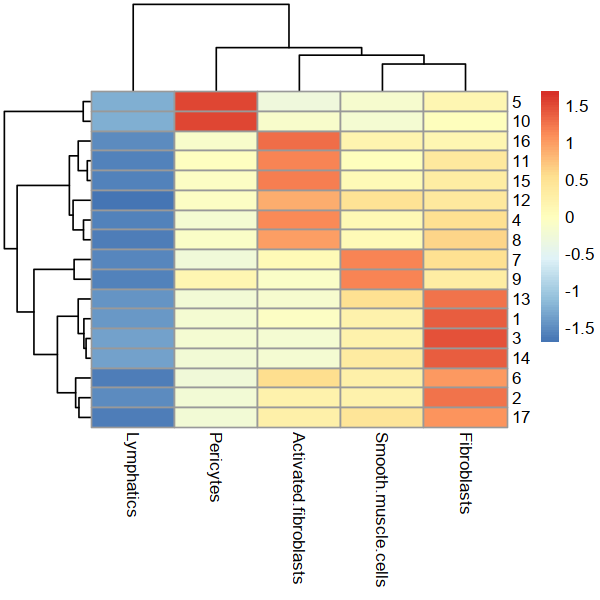

In [537]:
# genes_common <- intersect(row.names(exprs_norm), row.names(markers))# %>% intersect(genes_variable)
types_test <- c('Pericytes', 'Activated.fibroblasts', 'Smooth.muscle.cells', 'Fibroblasts', 'Lymphatics')
res <- cor(exprs_clusters[genes_common, ], markers[genes_common, types_test], method = 'spearman')
fig.size(5, 5)
pheatmap(res, scale = 'row')

In [551]:
name_list <- list(
    pericytes = c(5, 10), 
    fibroblasts = c(13, 1, 3, 14, 6, 2, 17), 
    activated_fibroblasts = c(16, 11, 15, 12, 4, 8),
    smooth_muscle = c(7, 9),
    `NA` = NA
)
cell_type <- name_clusters(name_list, clusters)


In [552]:
sum(table(cell_type)) 
length(clusters)
setdiff(unique(clusters,na.rm = TRUE), unlist(name_list))

[1] 1935

[1] 1935

numeric(0)

In [553]:
meta_data$cell_type_fine <- meta_data$cell_type_coarse
meta_data[idx, 'cell_type_fine'] <- cell_type

Warning message:
“Removed 5 rows containing missing values (geom_point_rast).”

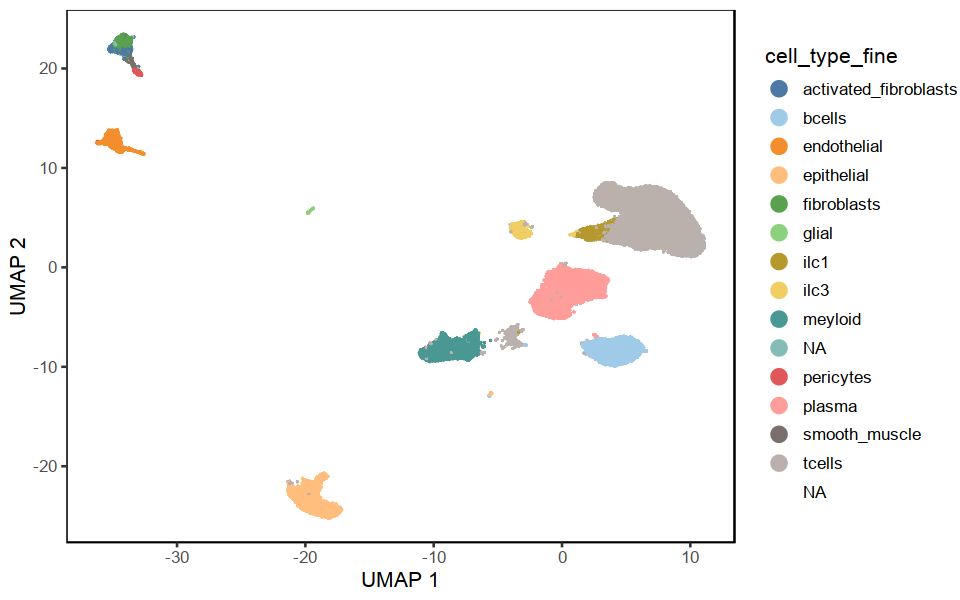

In [554]:
fig.size(5, 8)
do_scatter(umap_harmony, meta_data, 'cell_type_fine', palette_use = tableau_color_pal('Tableau 20')(20),
           do_labels = FALSE, no_guides = FALSE)


In [555]:
saveRDS(meta_data, '/data/srlab/ik936/Fiona/data/martin/meta_data_types.rds')

In [556]:
head(meta_data)

cell_id,sample,nUMI,nGene,percent_mito,cell_type_coarse,cell_type_fine
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>
AAACATTGGTGTCA_69,S69,4144,1277,0.012548263,mesenchymal,fibroblasts
AAACGCACTTAGGC_69,S69,5807,1727,0.006716032,mesenchymal,activated_fibroblasts
AAACGCTGCTACCC_69,S69,1330,627,0.010526316,tcells,tcells
AAACTTGAGTCACA_69,S69,3804,1327,0.013406940,mesenchymal,NA
AAACTTGATCACCC_69,S69,6330,864,0.006319115,plasma,plasma
AAAGACGAATCACG_69,S69,10294,2204,0.015348747,tcells,tcells


# Enrich modules

In [3]:
## meta_data, exprs_norm, vargenes_df, var_genes, hres, umap_harmony, V
load(file = '/data/srlab/ik936/Fiona/data/martin/cache.rda')

In [4]:
meta_data <- readRDS('/data/srlab/ik936/Fiona/data/martin/meta_data_types.rds')

In [5]:
head(meta_data)

cell_id,sample,nUMI,nGene,percent_mito,cell_type_coarse,cell_type_fine
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>
AAACATTGGTGTCA_69,S69,4144,1277,0.012548263,mesenchymal,fibroblasts
AAACGCACTTAGGC_69,S69,5807,1727,0.006716032,mesenchymal,activated_fibroblasts
AAACGCTGCTACCC_69,S69,1330,627,0.010526316,tcells,tcells
AAACTTGAGTCACA_69,S69,3804,1327,0.013406940,mesenchymal,NA
AAACTTGATCACCC_69,S69,6330,864,0.006319115,plasma,plasma
AAAGACGAATCACG_69,S69,10294,2204,0.015348747,tcells,tcells


In [6]:
table(meta_data$cell_type_fine)


activated_fibroblasts                bcells           endothelial 
                  450                  7456                  1700 
           epithelial           fibroblasts                 glial 
                 3629                  1001                   288 
                 ilc1                  ilc3               meyloid 
                 1293                  1337                  4314 
                   NA             pericytes                plasma 
                   25                   257                 10338 
        smooth_muscle                tcells 
                  202                 30154 

In [7]:
modules <- fread('data/WGCNA_all.csv')[, N := .N, by = moduleColor][N < 2000]

## Get cluster x gene 

In [8]:
y <- meta_data$cell_type_fine #obj$clusters_df[, 'res2']
idx <- which(!is.na(y) & y != 'NA')
y <- factor(y[idx])
exprs_use <- exprs_norm[, idx]

mod_df <- data.table(geneName = row.names(exprs_use)) %>% 
    dplyr::left_join(modules) 
genes_use <- which(!is.na(mod_df$moduleColor))

Joining, by = "geneName"



In [9]:
# exprs_fib_mean <- presto:::sumGroups(exprs_fib, y, 1)
exprs_fib_mean <- presto:::sumGroups(scaleData(exprs_use[genes_use, ]), y, 1)
exprs_fib_mean <- crossprod(exprs_fib_mean, diag(1 / table(y)))
row.names(exprs_fib_mean) <- genes_use #row.names(obj$exprs_norm)
colnames(exprs_fib_mean) <- levels(y)

Get cluster x module

In [10]:
y <- factor(mod_df[genes_use, 'moduleColor'])
mod_means <- presto::sumGroups(exprs_fib_mean, y)
mod_means <- crossprod(mod_means, diag(1 / table(y))) %>% t
row.names(mod_means) <- levels(y)
colnames(mod_means) <- colnames(exprs_fib_mean)

Scale the rows so that module size does not influence the total score

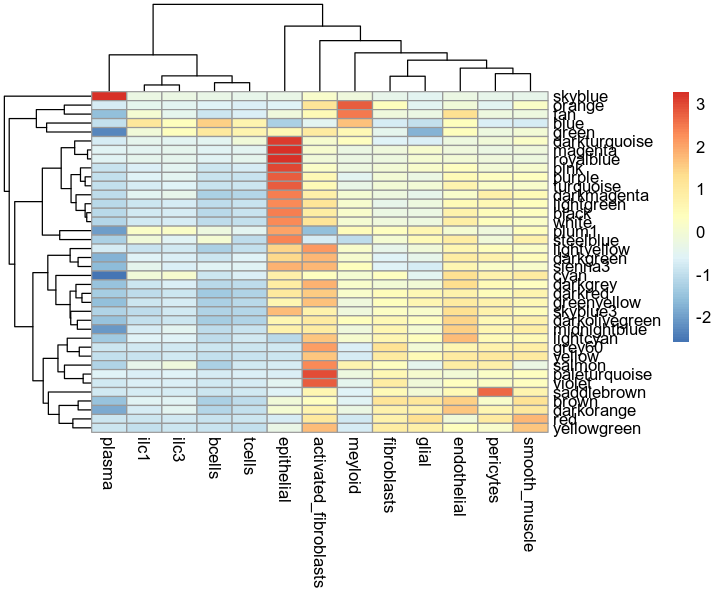

In [11]:
fig.size(5, 6)
library(pheatmap)
# pheatmap(t(apply(mod_means, 1, scales::rescale)))
# pheatmap(mod_means, scale = 'row')
plt_df <- mod_means %>% 
#     apply(1, scales::rescale) %>% t() %>% 
#     scale() %>%
    t() %>% scale() %>% t() %>% #scale() %>%
    identity()
# plt_df[abs(plt_df) < 2] <- 0
# plt_df[plt_df < 2] <- 0
pheatmap(plt_df, scale = 'none')

In [22]:
mod_means %>% saveRDS('/data/srlab/ik936/Fiona/data/scores_martin.rds')

# Cache

In [29]:
obj <- list()
obj$exprs_norm <- exprs_norm
obj$meta_data <- meta_data

obj %>% saveRDS('/data/srlab/ik936/Fiona/data/obj_martin.rds')
